# IoT WS22/23 Data Analytics
## Chapter 1: Data Preparation

### Load all the log files (JSON) and add the content into a data frame

In [1]:
import json
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Path to the json files
json_files = glob.glob("log*")
#json_files

In [3]:
# create empty df
df = pd.DataFrame()

In [4]:
x = 0
for i in json_files:
    # read line by line json files
    df_read = pd.read_json(json_files[x], lines=True)
    # concatenate the actual df with new json file
    df = pd.concat([df,df_read])
    # x+1 for iterate through file list
    x = x + 1

#df


In [5]:
# open dataframe head
#df.head()

## Filter the dataframe on relevant topics

In [6]:
# remove not used topics. Tasmota ID D863F9
df = df[df["topic"].str.contains("D863F9/SENSOR")==True]
#df 


In [7]:
# remove not used columns
df = df.drop(["time", "topic"], axis = 1)

In [8]:
#df

In [9]:
#check a random message
test = df.iloc[66861]['message']
#test


In [10]:
# This code is outdated, we´ve improved the perfomance with Chat GPT, check out the next cell
"""
for i, r in df.iterrows():
    # read line by line json files
    msg_raw = r["message"]
    msg_df = pd.json_normalize(msg_raw, errors='ignore')
    # concatenate the actual df with new json file
    msg_df2 = pd.concat([msg_df2,msg_df])

msg_df2
"""

'\nfor i, r in df.iterrows():\n    # read line by line json files\n    msg_raw = r["message"]\n    msg_df = pd.json_normalize(msg_raw, errors=\'ignore\')\n    # concatenate the actual df with new json file\n    msg_df2 = pd.concat([msg_df2,msg_df])\n\nmsg_df2\n'

In [11]:
#create two empty pd dataframes
msg_df = pd.DataFrame()
msg_df2 = pd.DataFrame()

# put information into a dataframe
def normalize_json(row):
    msg_raw = row["message"]
    msg_df = pd.json_normalize(msg_raw, errors='ignore')
    return msg_df

msg_df2 = df.apply(normalize_json, axis=1)
msg_df2 = pd.concat(msg_df2.tolist())

In [12]:
#msg_df2

In [13]:
# remove not used columns
cleandf = msg_df2.drop(["TempUnit", "DS18B20.Id"], axis = 1)
#cleandf

In [14]:
# sort dataframe by date
sortdf = cleandf.sort_values(by=['Time'])

In [15]:
# convert values for switch to int values
adaptdf = sortdf.replace({'Switch1': 'OFF'}, {'Switch1': 0}, regex=True)
adaptdf = adaptdf.replace( {'Switch1': 'ON'}, {'Switch1': 1}, regex=True)

In [16]:
# convert string time values to time values
finaldf = adaptdf
finaldf['Time'] = pd.to_datetime(finaldf['Time'], format='%Y-%m-%dT%H:%M:%S')

#finaldf

In [17]:
# reset index to be able to delete the row with the date from 1970
finaldf = finaldf.reset_index()
#finaldf

In [18]:
# drop the line with the date from 1970, presumably the default initialization date of the tasmota
rows_to_delete = finaldf.loc[finaldf['Time'] == "1970-01-01 00:04:02"]

# delete the selected rows
finaldf = finaldf.drop(rows_to_delete.index)

#finaldf

In [19]:
# calibrating temperature sensors: AM2301 needs +0.6 °C
finaldf['AM2301.Temperature'] = finaldf['AM2301.Temperature'].add(0.6)
finaldf

index                Time  Switch1  DS18B20.Temperature  \
1          0 2022-11-15 20:12:27        0                 12.6   
2          0 2022-11-15 20:12:57        0                 12.6   
3          0 2022-11-15 20:13:27        0                 12.6   
4          0 2022-11-15 20:13:57        0                 12.6   
5          0 2022-11-15 20:14:27        0                 12.6   
...      ...                 ...      ...                  ...   
88575      0 2022-12-17 09:57:45        1                 12.8   
88576      0 2022-12-17 09:58:15        1                 12.8   
88577      0 2022-12-17 09:58:45        1                 12.8   
88578      0 2022-12-17 09:59:15        1                 12.8   
88579      0 2022-12-17 09:59:45        1                 12.8   

       AM2301.Temperature  AM2301.Humidity  AM2301.DewPoint  \
1                    13.5             78.2              9.2   
2                    13.5             78.2              9.2   
3                    13.5             78.2              9.2   
4                    13.5             78.2              9.2   
5                    13.5             78.2              9.2   
...                   ...              ...              ...   
88575                16.7             52.5              6.4   
88576                16.7             52.5              6.4   
88577                16.6             52.5              6.3   
88578                16.7             52.5              6.4   
88579                16.7             52.5              6.4   

       BH1750.Illuminance  
1                     0.0  
2                     0.0  
3                     0.0  
4                     0.0  
5                     0.0  
...                   ...  
88575                 NaN  
88576                 NaN  
88577                 NaN  
88578                 NaN  
88579                 NaN  

[88579 rows x 8 columns]

In [20]:
# check the data
finaldf.describe()

index       Switch1  DS18B20.Temperature  AM2301.Temperature  \
count  88579.0  88579.000000         88579.000000        88579.000000   
mean       0.0      0.464557            14.257093           15.786260   
std        0.0      0.498745             2.917659            3.463454   
min        0.0      0.000000             8.300000            4.700000   
25%        0.0      0.000000            12.800000           15.500000   
50%        0.0      0.000000            15.600000           16.600000   
75%        0.0      1.000000            16.700000           18.400000   
max        0.0      1.000000            20.400000           33.200000   

       AM2301.Humidity  AM2301.DewPoint  BH1750.Illuminance  
count     88579.000000     88579.000000        43457.000000  
mean         68.740939         9.262844            9.069011  
std          10.515844         2.093712          123.456020  
min          33.500000        -4.700000            0.000000  
25%          59.000000         6.800000            0.000000  
50%          68.300000        10.100000            0.000000  
75%          78.000000        11.000000            3.000000  
max          98.000000        14.700000         2517.000000

### Import Outdoor Temp/Hum/Dew

In [21]:
# import the csv file generated on https://www.meteostat.net
out1 = pd.read_csv('outdoor_temp.csv')
# generate out1 and out2 for two timeframes
out2 = out1

In [22]:
# drop not needed columns
out1 = out1.drop(["prcp", "snow", "wdir","wspd","wpgt","pres","tsun","coco"], axis = 1)
out2 = out2.drop(["prcp", "snow", "wdir","wspd","wpgt","pres","tsun","coco"], axis = 1)

In [23]:
# filter rows based on needed time period
deleterows1 = out1.loc[out1['time'] < '2022-11-15 22:00:00']
deleterows2 = out1.loc[out1['time'] > '2022-11-20 09:00:00']

# delete the selected rows
out1 = out1.drop(deleterows1.index)
out1 = out1.drop(deleterows2.index)

# check the data
out1

time  temp  dwpt  rhum
22   2022-11-15 22:00:00   6.7   6.1    96
23   2022-11-15 23:00:00   6.4   5.7    95
24   2022-11-16 00:00:00   6.5   5.6    94
25   2022-11-16 01:00:00   6.8   5.9    94
26   2022-11-16 02:00:00   6.8   5.9    94
..                   ...   ...   ...   ...
125  2022-11-20 05:00:00   2.7   1.2    90
126  2022-11-20 06:00:00   2.5   1.5    93
127  2022-11-20 07:00:00   3.0   1.7    91
128  2022-11-20 08:00:00   3.4   2.2    92
129  2022-11-20 09:00:00   4.1   2.3    88

[108 rows x 4 columns]

In [24]:
# filter rows based on needed time period
deleterows3 = out2.loc[out2['time'] < '2022-11-20 10:00:00']
deleterows4 = out2.loc[out2['time'] > '2022-11-24 18:00:00']

# delete the selected rows
out2 = out2.drop(deleterows3.index)
out2 = out2.drop(deleterows4.index)

# check the data
out2

time  temp  dwpt  rhum
130  2022-11-20 10:00:00   4.4   2.4    87
131  2022-11-20 11:00:00   5.1   2.6    84
132  2022-11-20 12:00:00   6.1   2.9    80
133  2022-11-20 13:00:00   6.3   3.6    83
134  2022-11-20 14:00:00   6.6   3.6    81
..                   ...   ...   ...   ...
230  2022-11-24 14:00:00   7.9   6.2    89
231  2022-11-24 15:00:00   8.2   5.7    84
232  2022-11-24 16:00:00   7.9   4.8    81
233  2022-11-24 17:00:00   6.6   3.6    81
234  2022-11-24 18:00:00   6.1   2.4    77

[105 rows x 4 columns]

In [25]:
# visualize outdoor temp of out1
#out1.plot.line(x='time', y = ['temp'], figsize=(20,8), grid=True)

# 2. Aufgabe 1: Vorgegebene Versuchsaufbauten

## 2.1 Aufgabe 1.1: Thermische Untersuchung eines Wohnraums

In [26]:
# Datensatz nach Zeitraum filtern
#15.11. - 20.11.
start1 = '2022-11-15 22:00:00'
end1 = '2022-11-20 09:00:00'
df1_1 = finaldf.drop(["Switch1", "BH1750.Illuminance"], axis = 1)
df1_1 = df1_1[(df1_1['Time'] >= start1) & (df1_1['Time'] <= end1)]

#20.11. - 24.11.
start2 = '2022-11-20 10:00:00'
end2 = '2022-11-24 18:00:00'
df1_2 = finaldf.drop(["Switch1", "BH1750.Illuminance"], axis = 1)
df1_2 = df1_2[(df1_2['Time'] >= start2) & (df1_2['Time'] <= end2)]

In [27]:
#df1_2


### Zeitraum 1

(0.0, 22.0)

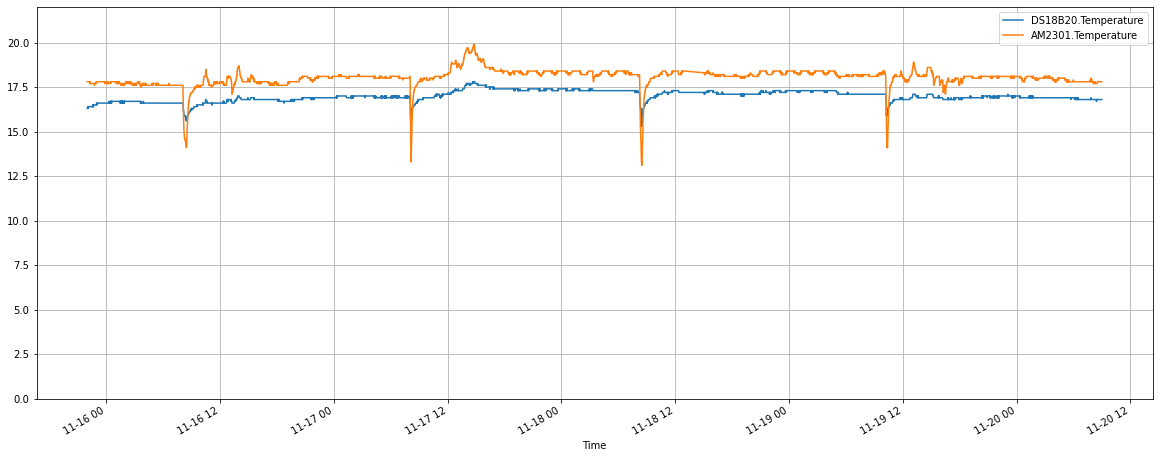

In [28]:
# plot des ersten Zeitraumes beider temp sensoren
df1_1.plot.line(x='Time', y = ['DS18B20.Temperature', 'AM2301.Temperature'], figsize=(20,8), grid=True)
plt.ylim(0, 22)

(0.0, 22.0)

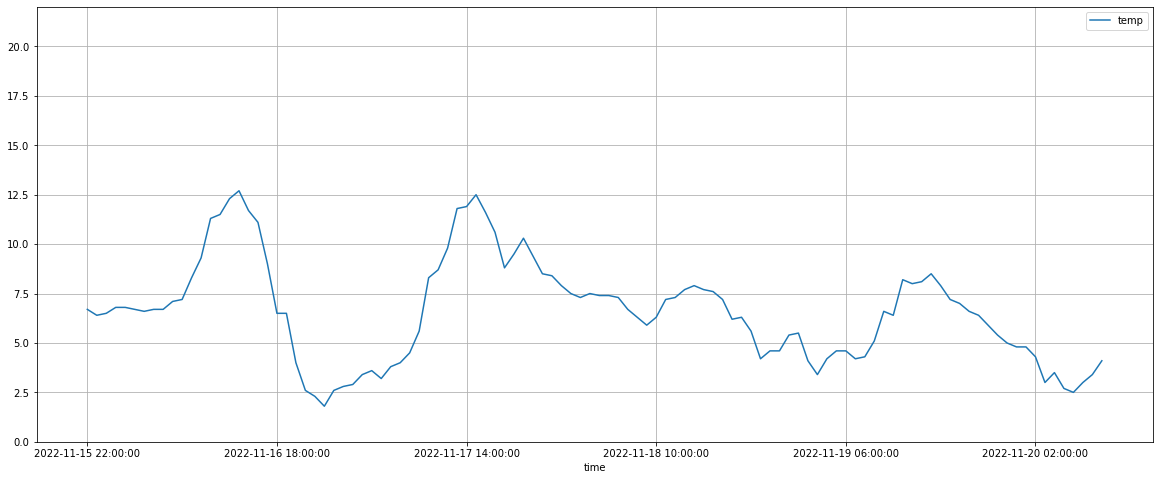

In [29]:
# plot der zugehörigen Außentemp
out1.plot.line(x='time', y = ['temp'], figsize=(20,8), grid=True)
plt.ylim(0, 22)

(0.0, 80.0)

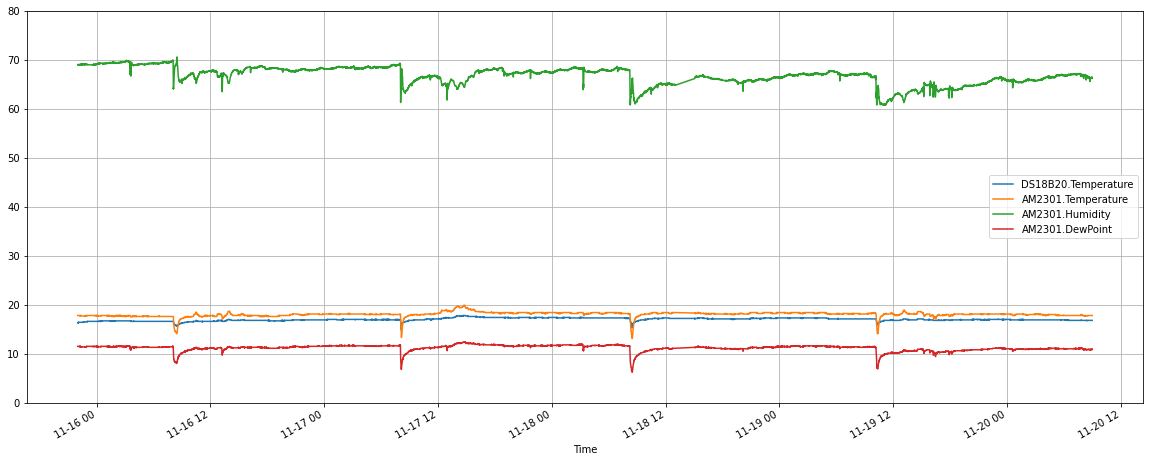

In [30]:
# plot der Luftfeuchtigkeit, Taupunkt und beider Tempsensoren, alles innen
df1_1.plot.line(x='Time', y = ['DS18B20.Temperature', 'AM2301.Temperature', 'AM2301.Humidity', 'AM2301.DewPoint'], figsize=(20,8), grid=True) 
plt.ylim(0, 80)

### Zeitraum 2

(0.0, 22.0)

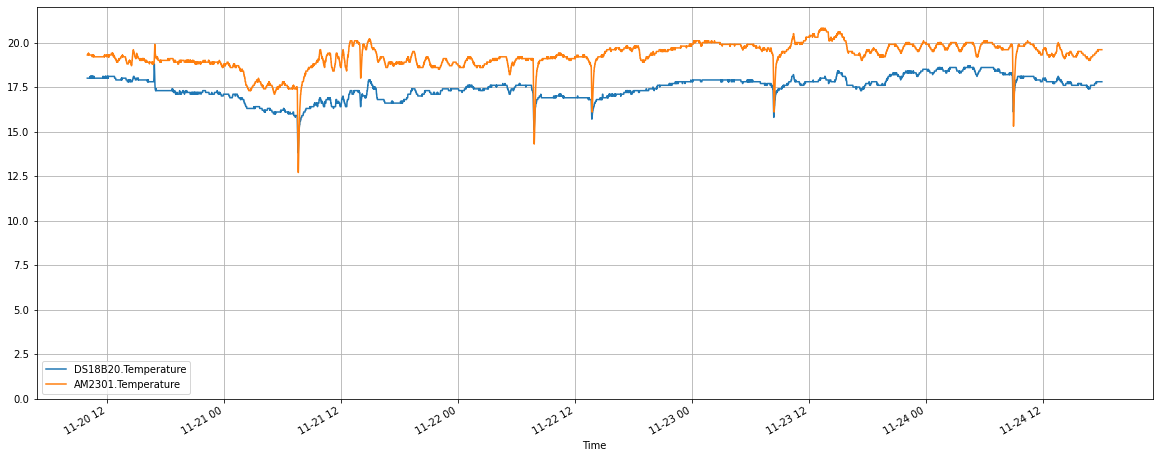

In [31]:
# plot des zweiten Zeitraumes beider temp sensoren
df1_2.plot.line(x='Time', y = ['DS18B20.Temperature', 'AM2301.Temperature'], figsize=(20,8), grid=True)
plt.ylim(0, 22)

(0.0, 22.0)

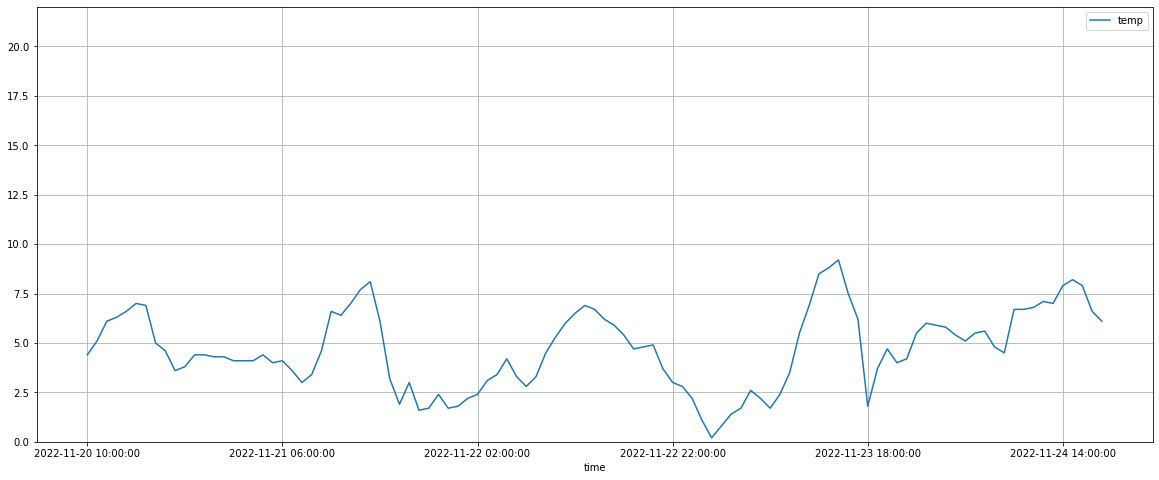

In [32]:
# plot der zugehörigen Außentemp
out2.plot.line(x='time', y = ['temp'], figsize=(20,8), grid=True)
plt.ylim(0, 22)
#ax.set_ylim(-5, 23)
# plt.show()

(0.0, 80.0)

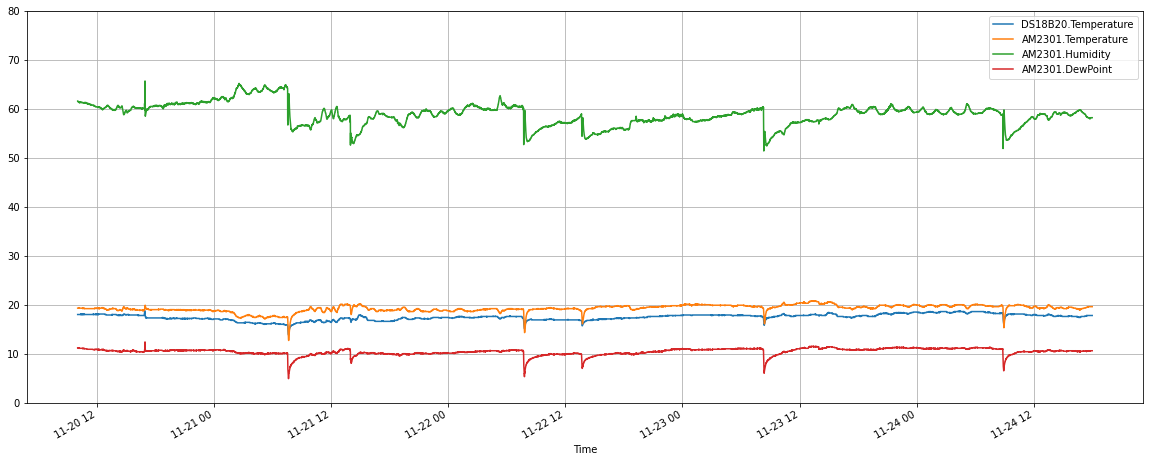

In [33]:
# plot der Luftfeuchtigkeit, Taupunkt und beider Tempsensoren, alles innen
df1_2.plot.line(x='Time', y = ['DS18B20.Temperature', 'AM2301.Temperature', 'AM2301.Humidity', 'AM2301.DewPoint'], figsize=(20,8), grid=True) 
plt.ylim(0, 80)

### Behaglichkeit

In [34]:
startb = '2022-11-24 08:00:00'
endb = '2022-11-24 18:00:00'
dfb = finaldf.drop(["Switch1", "BH1750.Illuminance"], axis = 1)
dfb = dfb[(dfb['Time'] > startb) & (dfb['Time'] < endb)]
dfb.describe()

index  DS18B20.Temperature  AM2301.Temperature  AM2301.Humidity  \
count  1199.0          1199.000000         1199.000000      1199.000000   
mean      0.0            17.822602           19.443703        57.999416   
std       0.0             0.266301            0.506016         1.616507   
min       0.0            16.100000           15.300000        51.900000   
25%       0.0            17.600000           19.300000        57.700000   
50%       0.0            17.800000           19.500000        58.700000   
75%       0.0            18.000000           19.700000        59.100000   
max       0.0            18.300000           20.100000        59.900000   

       AM2301.DewPoint  
count      1199.000000  
mean         10.381151  
std           0.556817  
min           6.500000  
25%          10.400000  
50%          10.500000  
75%          10.600000  
max          11.000000

## 2.2 Aufgabe 1.2: Nutzungsroutine von Raumbeleuchtungen

## Messreihe 1

In [35]:
# Datensatz nach Zeitraum sortieren
#24.11. - 01.12.
start3 = '2022-11-24 20:00:00'
end3 = '2022-12-01 19:00:00'
df1_3 = finaldf.drop(['DS18B20.Temperature', 'AM2301.Temperature', 'AM2301.Humidity', 'AM2301.DewPoint'], axis = 1)
df1_3 = df1_3[(df1_3['Time'] >= start3) & (df1_3['Time'] <= end3)]

#02.12. - 09.12.
start4 = '2022-12-01 20:00:00'
end4 = '2022-12-09 19:00:00'
df1_4 = finaldf.drop(['DS18B20.Temperature', 'AM2301.Temperature', 'AM2301.Humidity', 'AM2301.DewPoint'], axis = 1)
df1_4 = df1_4[(df1_4['Time'] >= start4) & (df1_4['Time'] <= end4)]

In [36]:
df1_3.describe()

index       Switch1  BH1750.Illuminance
count  18162.0  18162.000000        18162.000000
mean       0.0      0.015637           17.184066
std        0.0      0.124070          186.018026
min        0.0      0.000000            0.000000
25%        0.0      0.000000            0.000000
50%        0.0      0.000000            0.000000
75%        0.0      0.000000            4.000000
max        0.0      1.000000         2517.000000

<AxesSubplot:xlabel='Time'>

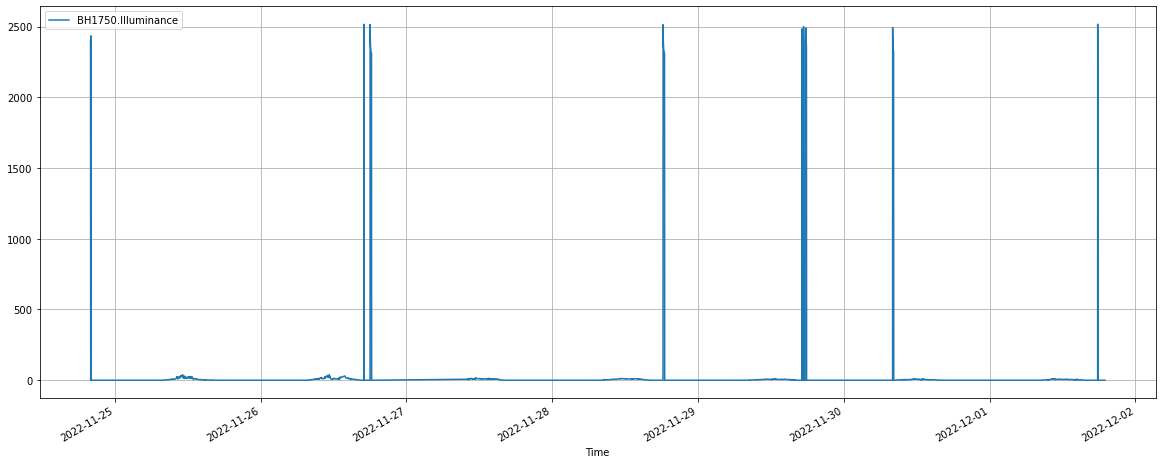

In [37]:
# plotte die Helligkeit
df1_3.plot.line(x='Time', y = ["BH1750.Illuminance"], figsize=(20,8), grid=True)

<AxesSubplot:xlabel='Time'>

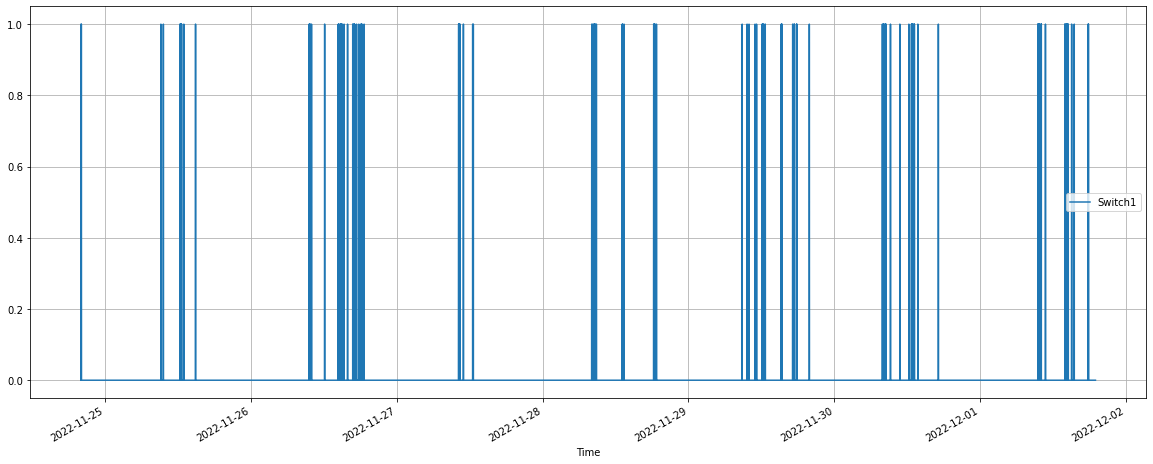

In [38]:
# plotte die Bewegungserkennung
df1_3.plot.line(x='Time', y = ["Switch1"], figsize=(20,8), grid=True)

In [39]:
# create a boolean mask indicating which values in column are above 200
mask = df1_3['BH1750.Illuminance'] > 200

# set the values in column to 1 if they are above 200, and False otherwise
df1_3.loc[mask, 'BH1750.Illuminance'] = 1
df1_3.loc[~mask, 'BH1750.Illuminance'] = 0



In [40]:
df1_3

index                Time  Switch1  BH1750.Illuminance
25627      0 2022-11-24 20:00:22        0                 1.0
25628      0 2022-11-24 20:00:52        1                 1.0
25629      0 2022-11-24 20:01:29        1                 1.0
25630      0 2022-11-24 20:01:59        0                 0.0
25631      0 2022-11-24 20:02:29        0                 0.0
...      ...                 ...      ...                 ...
43784      0 2022-12-01 18:57:35        0                 0.0
43785      0 2022-12-01 18:58:05        0                 0.0
43786      0 2022-12-01 18:58:35        0                 0.0
43787      0 2022-12-01 18:59:05        0                 0.0
43788      0 2022-12-01 18:59:35        0                 0.0

[18162 rows x 4 columns]

In [41]:
#           S1/Illum/Cond
# Zustand 1: 0/0 --> Gut
# Zustand 2: 0/1 --> Schlecht
# Zustand 3: 1/0 --> Gut
# Zustand 4: 1/1 --> Gut

In [42]:
# Erstelle eine Spalte Condition mit den Werten 0 und 1, basierend auf welche relevant werden
def new_column(row):
    if ((row['Switch1'] == 0) & (row['BH1750.Illuminance'] == 0)):
        return 0
    elif ((row['Switch1'] == 1) & (row['BH1750.Illuminance'] == 0)):
        return 0
    elif ((row['Switch1'] == 1) & (row['BH1750.Illuminance'] == 1)):
        return 0
    else:
        return 1

df1_3['Condition'] = df1_3.apply(new_column, axis=1)


In [43]:
df1_3


index                Time  Switch1  BH1750.Illuminance  Condition
25627      0 2022-11-24 20:00:22        0                 1.0          1
25628      0 2022-11-24 20:00:52        1                 1.0          0
25629      0 2022-11-24 20:01:29        1                 1.0          0
25630      0 2022-11-24 20:01:59        0                 0.0          0
25631      0 2022-11-24 20:02:29        0                 0.0          0
...      ...                 ...      ...                 ...        ...
43784      0 2022-12-01 18:57:35        0                 0.0          0
43785      0 2022-12-01 18:58:05        0                 0.0          0
43786      0 2022-12-01 18:58:35        0                 0.0          0
43787      0 2022-12-01 18:59:05        0                 0.0          0
43788      0 2022-12-01 18:59:35        0                 0.0          0

[18162 rows x 5 columns]

<AxesSubplot:xlabel='Time'>

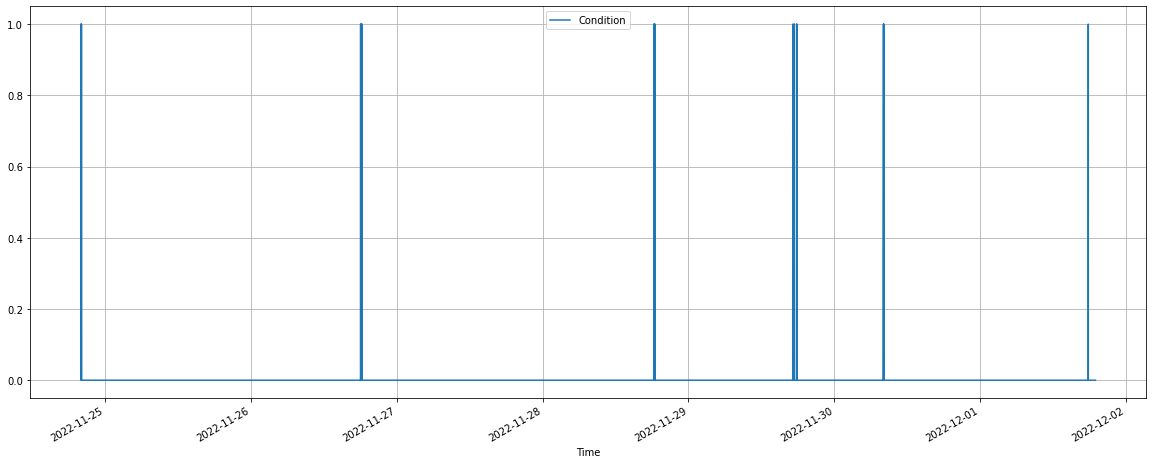

In [44]:
# plotte die Condition = Werte die 1 sind, sind die "schlechten" Zustände
df1_3.plot.line(x='Time', y = ['Condition'], figsize=(20,8), grid=True)

To Do:
    1. Wenn außerhalb Messbereich Switch1, aber Zeitdelta <3min, dann muss es ok sein. 
       D.h. Eine 1 bei Condition soll zur 0 werden. 
    

In [45]:
# erstelle eine neue Spalte mit den Werten von Condition um eine Reihe verschoben um Zustandsänderungen ermitteln zu können
df1_3['CellBefore'] = df1_3['Condition'].shift(periods=1)

In [46]:
df1_3

index                Time  Switch1  BH1750.Illuminance  Condition  \
25627      0 2022-11-24 20:00:22        0                 1.0          1   
25628      0 2022-11-24 20:00:52        1                 1.0          0   
25629      0 2022-11-24 20:01:29        1                 1.0          0   
25630      0 2022-11-24 20:01:59        0                 0.0          0   
25631      0 2022-11-24 20:02:29        0                 0.0          0   
...      ...                 ...      ...                 ...        ...   
43784      0 2022-12-01 18:57:35        0                 0.0          0   
43785      0 2022-12-01 18:58:05        0                 0.0          0   
43786      0 2022-12-01 18:58:35        0                 0.0          0   
43787      0 2022-12-01 18:59:05        0                 0.0          0   
43788      0 2022-12-01 18:59:35        0                 0.0          0   

       CellBefore  
25627         NaN  
25628         1.0  
25629         0.0  
25630         0.0  
25631         0.0  
...           ...  
43784         0.0  
43785         0.0  
43786         0.0  
43787         0.0  
43788         0.0  

[18162 rows x 6 columns]

In [47]:
# Select the rows where the value in column BH1750.Illuminance is less than 1 = no light on

rows_to_delete = df1_3.loc[df1_3['BH1750.Illuminance'] < 1] 

# Delete the selected rows

df1_3 = df1_3.drop(rows_to_delete.index)

In [48]:
# Select the rows which are irrelevant, as they are the 'good' conditions
rows_to_delete2 = df1_3.loc[((df1_3['CellBefore'] == 1) & (df1_3['Condition'] == 0)) 
| ((df1_3['CellBefore'] == 0) & (df1_3['Condition'] == 1))]

# Delete the selected rows

df1_3 = df1_3.drop(rows_to_delete2.index)

In [49]:
# Introduce column Timediff for calculate the time between the state changes
df1_3['Timediff'] = df1_3['Time'].diff()

In [50]:
# select the rows which have less then 3 mins time difference
rows_to_delete3 = df1_3.loc[((df1_3['Timediff'] < '0 days 00:03:00'))]

# Delete the selected rows

df1_3 = df1_3.drop(rows_to_delete3.index)

In [51]:
df1_3.describe()

index    Switch1  BH1750.Illuminance  Condition  CellBefore  \
count   10.0  10.000000                10.0  10.000000    9.000000   
mean     0.0   0.800000                 1.0   0.200000    0.111111   
std      0.0   0.421637                 0.0   0.421637    0.333333   
min      0.0   0.000000                 1.0   0.000000    0.000000   
25%      0.0   1.000000                 1.0   0.000000    0.000000   
50%      0.0   1.000000                 1.0   0.000000    0.000000   
75%      0.0   1.000000                 1.0   0.000000    0.000000   
max      0.0   1.000000                 1.0   1.000000    1.000000   

                        Timediff  
count                          9  
mean   0 days 18:20:27.333333333  
std    0 days 19:48:57.861088975  
min              0 days 00:04:00  
25%              0 days 00:22:00  
50%              0 days 14:12:01  
75%              1 days 09:35:25  
max              2 days 00:00:04

In [52]:
rows_to_delete4 = df1_3.loc[((df1_3['Condition'] == 0))]

# Delete the selected rows

df1_3 = df1_3.drop(rows_to_delete4.index)

In [53]:
df1_3.describe()

index  Switch1  BH1750.Illuminance  Condition  CellBefore  \
count    2.0      2.0                 2.0        2.0         1.0   
mean     0.0      0.0                 1.0        1.0         1.0   
std      0.0      0.0                 0.0        0.0         NaN   
min      0.0      0.0                 1.0        1.0         1.0   
25%      0.0      0.0                 1.0        1.0         1.0   
50%      0.0      0.0                 1.0        1.0         1.0   
75%      0.0      0.0                 1.0        1.0         1.0   
max      0.0      0.0                 1.0        1.0         1.0   

              Timediff  
count                1  
mean   0 days 00:04:00  
std                NaT  
min    0 days 00:04:00  
25%    0 days 00:04:00  
50%    0 days 00:04:00  
75%    0 days 00:04:00  
max    0 days 00:04:00

In [54]:
df1_3

index                Time  Switch1  BH1750.Illuminance  Condition  \
25627      0 2022-11-24 20:00:22        0                 1.0          1   
25637      0 2022-11-24 20:05:29        0                 1.0          1   

       CellBefore        Timediff  
25627         NaN             NaT  
25637         1.0 0 days 00:04:00

In [55]:
sumdf1_3 = df1_3['Timediff'].sum()
sumdf1_3

Timedelta('0 days 00:04:00')

## Messreihe 2

In [56]:
# Datensatz nach Zeitraum sortieren

#02.12. - 09.12.
start4 = '2022-12-01 20:00:00'
end4 = '2022-12-09 19:00:00'
df1_4 = finaldf.drop(['DS18B20.Temperature', 'AM2301.Temperature', 'AM2301.Humidity', 'AM2301.DewPoint'], axis = 1)
df1_4 = df1_4[(df1_4['Time'] >= start4) & (df1_4['Time'] <= end4)]

In [57]:
df1_4.describe()

index       Switch1  BH1750.Illuminance
count  22849.0  22849.000000        22849.000000
mean       0.0      0.005427            2.724277
std        0.0      0.073469            7.024208
min        0.0      0.000000            0.000000
25%        0.0      0.000000            0.000000
50%        0.0      0.000000            0.000000
75%        0.0      0.000000            3.000000
max        0.0      1.000000           67.000000

<AxesSubplot:xlabel='Time'>

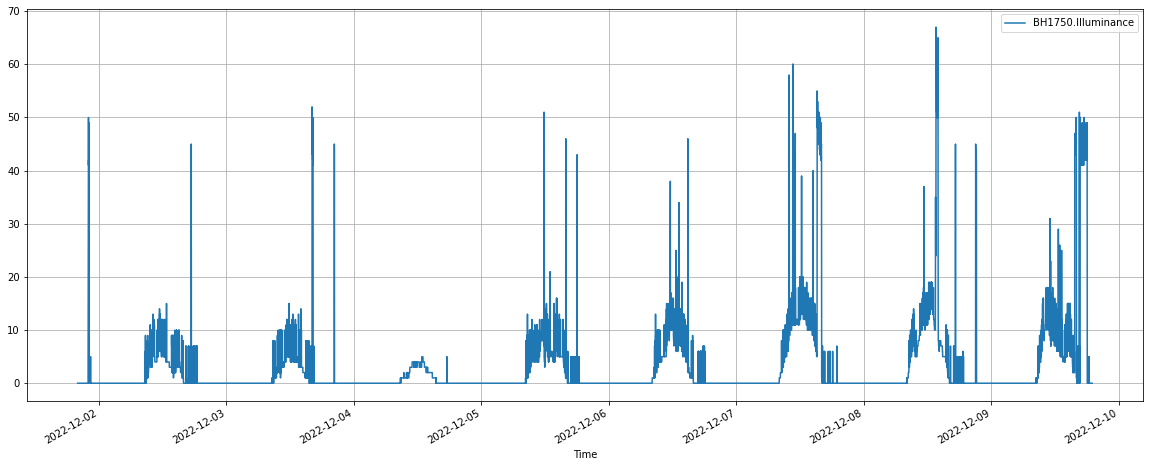

In [58]:
# plotte die Helligkeit
df1_4.plot.line(x='Time', y = ["BH1750.Illuminance"], figsize=(20,8), grid=True)

<AxesSubplot:xlabel='Time'>

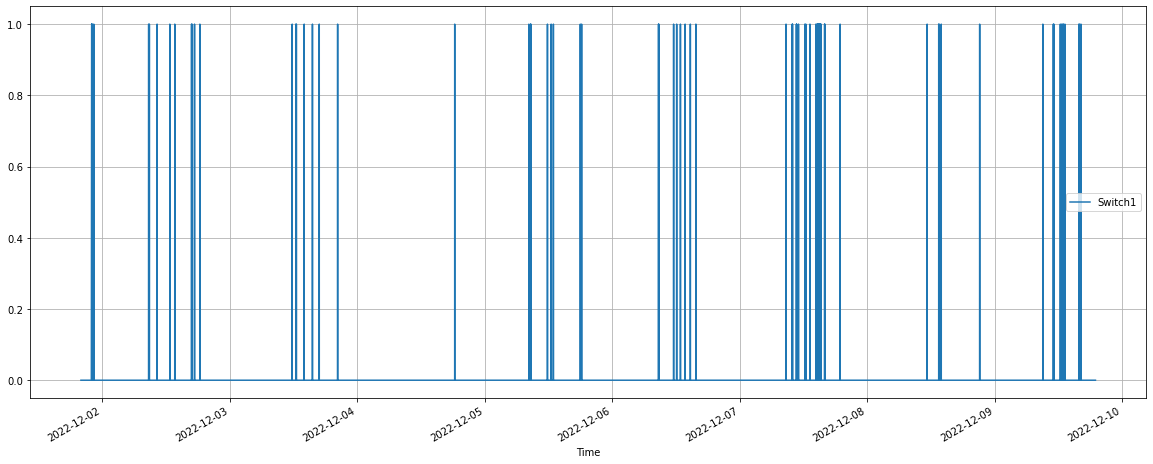

In [59]:
# plotte die Bewegungserkennung
df1_4.plot.line(x='Time', y = ["Switch1"], figsize=(20,8), grid=True)

In [60]:
# create a boolean mask indicating which values in column are above 33
mask = df1_4['BH1750.Illuminance'] > 33

# set the values in column to 1 if they are above 200, and False otherwise
df1_4.loc[mask, 'BH1750.Illuminance'] = 1
df1_4.loc[~mask, 'BH1750.Illuminance'] = 0


In [61]:
df1_4

index                Time  Switch1  BH1750.Illuminance
43909      0 2022-12-01 20:00:05        0                 0.0
43910      0 2022-12-01 20:00:35        0                 0.0
43911      0 2022-12-01 20:01:05        0                 0.0
43912      0 2022-12-01 20:01:35        0                 0.0
43913      0 2022-12-01 20:02:05        0                 0.0
...      ...                 ...      ...                 ...
66753      0 2022-12-09 18:57:50        0                 0.0
66754      0 2022-12-09 18:58:20        0                 0.0
66755      0 2022-12-09 18:58:50        0                 0.0
66756      0 2022-12-09 18:59:20        0                 0.0
66757      0 2022-12-09 18:59:50        0                 0.0

[22849 rows x 4 columns]

In [62]:
#           S1/Illum/Cond
# Zustand 1: 0/0 --> Gut
# Zustand 2: 0/1 --> Schlecht
# Zustand 3: 1/0 --> Gut
# Zustand 4: 1/1 --> Gut

In [63]:
# Erstelle eine Spalte Condition mit den Werten 0 und 1, basierend auf welche relevant werden
def new_column(row):
    if ((row['Switch1'] == 0) & (row['BH1750.Illuminance'] == 0)):
        return 0
    elif ((row['Switch1'] == 1) & (row['BH1750.Illuminance'] == 0)):
        return 0
    elif ((row['Switch1'] == 1) & (row['BH1750.Illuminance'] == 1)):
        return 0
    else:
        return 1

df1_4['Condition'] = df1_4.apply(new_column, axis=1)

In [64]:
df1_4


index                Time  Switch1  BH1750.Illuminance  Condition
43909      0 2022-12-01 20:00:05        0                 0.0          0
43910      0 2022-12-01 20:00:35        0                 0.0          0
43911      0 2022-12-01 20:01:05        0                 0.0          0
43912      0 2022-12-01 20:01:35        0                 0.0          0
43913      0 2022-12-01 20:02:05        0                 0.0          0
...      ...                 ...      ...                 ...        ...
66753      0 2022-12-09 18:57:50        0                 0.0          0
66754      0 2022-12-09 18:58:20        0                 0.0          0
66755      0 2022-12-09 18:58:50        0                 0.0          0
66756      0 2022-12-09 18:59:20        0                 0.0          0
66757      0 2022-12-09 18:59:50        0                 0.0          0

[22849 rows x 5 columns]

<AxesSubplot:xlabel='Time'>

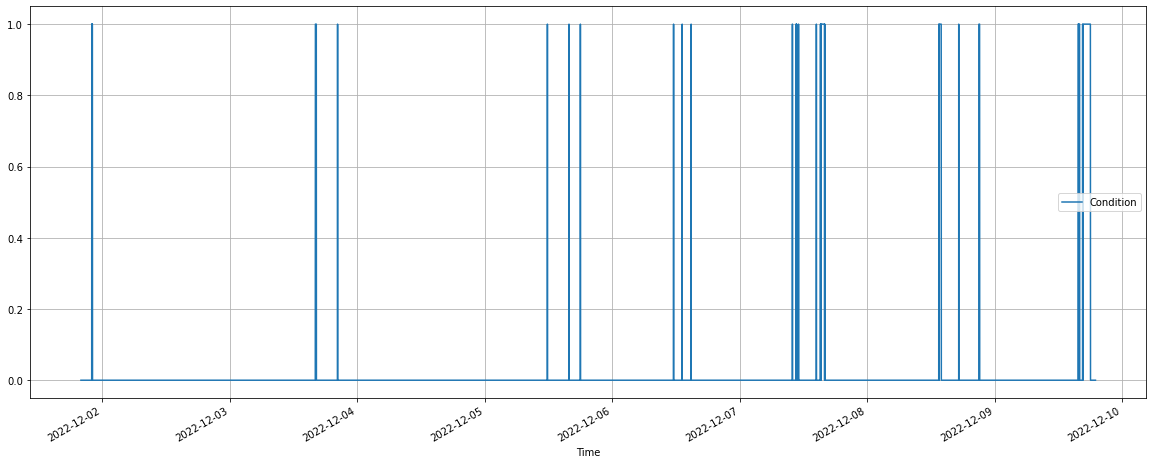

In [65]:
# plotte die Condition = Werte die 1 sind, sind die "schlechten" Zustände
df1_4.plot.line(x='Time', y = ['Condition'], figsize=(20,8), grid=True)

In [66]:
# erstelle eine neue Spalte mit den Werten von Condition um eine Reihe verschoben um Zustandsänderungen ermitteln zu können
df1_4['CellBefore'] = df1_3['Condition'].shift(periods=1)

In [67]:
df1_4

index                Time  Switch1  BH1750.Illuminance  Condition  \
43909      0 2022-12-01 20:00:05        0                 0.0          0   
43910      0 2022-12-01 20:00:35        0                 0.0          0   
43911      0 2022-12-01 20:01:05        0                 0.0          0   
43912      0 2022-12-01 20:01:35        0                 0.0          0   
43913      0 2022-12-01 20:02:05        0                 0.0          0   
...      ...                 ...      ...                 ...        ...   
66753      0 2022-12-09 18:57:50        0                 0.0          0   
66754      0 2022-12-09 18:58:20        0                 0.0          0   
66755      0 2022-12-09 18:58:50        0                 0.0          0   
66756      0 2022-12-09 18:59:20        0                 0.0          0   
66757      0 2022-12-09 18:59:50        0                 0.0          0   

       CellBefore  
43909         NaN  
43910         NaN  
43911         NaN  
43912         NaN  
43913         NaN  
...           ...  
66753         NaN  
66754         NaN  
66755         NaN  
66756         NaN  
66757         NaN  

[22849 rows x 6 columns]

In [68]:
# Select the rows where the value in column BH1750.Illuminance is less than 1 = no light on

rows_to_delete = df1_4.loc[df1_4['BH1750.Illuminance'] < 1] 

# Delete the selected rows

df1_4 = df1_4.drop(rows_to_delete.index)

In [69]:
# Select the rows which are irrelevant, as they are the 'good' conditions
rows_to_delete2 = df1_4.loc[((df1_4['CellBefore'] == 1) & (df1_4['Condition'] == 0)) 
| ((df1_4['CellBefore'] == 0) & (df1_4['Condition'] == 1))]

# Delete the selected rows

df1_4 = df1_4.drop(rows_to_delete2.index)

In [70]:
# Introduce column Timediff for calculate the time between the state changes
df1_4['Timediff'] = df1_4['Time'].diff()

In [71]:
# select the rows which have less then 3 mins time difference
rows_to_delete3 = df1_4.loc[((df1_4['Timediff'] < '0 days 00:03:00'))]

# Delete the selected rows

df1_4 = df1_4.drop(rows_to_delete3.index)

In [72]:
df1_4.describe()

index    Switch1  BH1750.Illuminance  Condition  CellBefore  \
count   25.0  25.000000                25.0  25.000000         0.0   
mean     0.0   0.320000                 1.0   0.680000         NaN   
std      0.0   0.476095                 0.0   0.476095         NaN   
min      0.0   0.000000                 1.0   0.000000         NaN   
25%      0.0   0.000000                 1.0   0.000000         NaN   
50%      0.0   0.000000                 1.0   1.000000         NaN   
75%      0.0   1.000000                 1.0   1.000000         NaN   
max      0.0   1.000000                 1.0   1.000000         NaN   

                        Timediff  
count                         24  
mean      0 days 07:41:00.750000  
std    0 days 10:24:27.768365391  
min              0 days 00:04:00  
25%       0 days 00:43:22.500000  
50%              0 days 02:10:44  
75%              0 days 17:46:17  
max              1 days 15:28:34

In [73]:
rows_to_delete4 = df1_4.loc[((df1_4['Condition'] == 0))]

# Delete the selected rows

df1_4 = df1_4.drop(rows_to_delete4.index)

In [74]:
df1_4.describe()

index  Switch1  BH1750.Illuminance  Condition  CellBefore  \
count   17.0     17.0                17.0       17.0         0.0   
mean     0.0      0.0                 1.0        1.0         NaN   
std      0.0      0.0                 0.0        0.0         NaN   
min      0.0      0.0                 1.0        1.0         NaN   
25%      0.0      0.0                 1.0        1.0         NaN   
50%      0.0      0.0                 1.0        1.0         NaN   
75%      0.0      0.0                 1.0        1.0         NaN   
max      0.0      0.0                 1.0        1.0         NaN   

                        Timediff  
count                         17  
mean   0 days 07:12:14.764705882  
std    0 days 10:56:37.200737376  
min              0 days 00:04:00  
25%              0 days 00:38:30  
50%              0 days 02:10:58  
75%              0 days 04:03:00  
max              1 days 15:28:34

In [75]:
df1_4

index                Time  Switch1  BH1750.Illuminance  Condition  \
49181      0 2022-12-03 16:07:38        0                 1.0          1   
49682      0 2022-12-03 20:18:08        0                 1.0          1   
54414      0 2022-12-05 11:48:12        0                 1.0          1   
54904      0 2022-12-05 15:53:12        0                 1.0          1   
57264      0 2022-12-06 11:33:14        0                 1.0          1   
57461      0 2022-12-06 13:11:44        0                 1.0          1   
57663      0 2022-12-06 14:52:44        0                 1.0          1   
60030      0 2022-12-07 10:36:16        0                 1.0          1   
60492      0 2022-12-07 14:27:16        0                 1.0          1   
63238      0 2022-12-08 13:29:46        0                 1.0          1   
63248      0 2022-12-08 13:34:46        0                 1.0          1   
63687      0 2022-12-08 17:15:19        0                 1.0          1   
64142      0 2022-12-08 21:02:49        0                 1.0          1   
66370      0 2022-12-09 15:42:21        0                 1.0          1   
66474      0 2022-12-09 16:34:21        0                 1.0          1   
66486      0 2022-12-09 16:40:21        0                 1.0          1   
66617      0 2022-12-09 17:49:50        0                 1.0          1   

       CellBefore        Timediff  
49181         NaN 0 days 22:44:32  
49682         NaN 0 days 03:59:30  
54414         NaN 1 days 15:28:34  
54904         NaN 0 days 04:03:00  
57264         NaN 0 days 17:31:32  
57461         NaN 0 days 01:37:30  
57663         NaN 0 days 01:41:00  
60030         NaN 0 days 00:38:30  
60492         NaN 0 days 02:10:30  
63238         NaN 0 days 02:10:58  
63248         NaN 0 days 00:04:30  
63687         NaN 0 days 03:17:03  
64142         NaN 0 days 03:47:30  
66370         NaN 0 days 18:30:32  
66474         NaN 0 days 00:33:30  
66486         NaN 0 days 00:05:30  
66617         NaN 0 days 00:04:00

In [76]:
sumdf1_4 = df1_4['Timediff'].sum()
sumdf1_4

Timedelta('5 days 02:28:11')

# 3 Aufgabe 2: Eigener Versuchsaufbau

In [77]:
# Datensatz nach Zeitraum sortieren
# 10.12. - 17.12.
start5 = '2022-12-10 21:00:00'
end5 = '2022-12-17 10:00:00'
df1_5 = finaldf.drop(['DS18B20.Temperature', 'AM2301.Temperature', 'AM2301.Humidity', 'AM2301.DewPoint', 'BH1750.Illuminance'], axis = 1)
df1_5 = df1_5[(df1_5['Time'] >= start5) & (df1_5['Time'] <= end5)]

<AxesSubplot:xlabel='Time'>

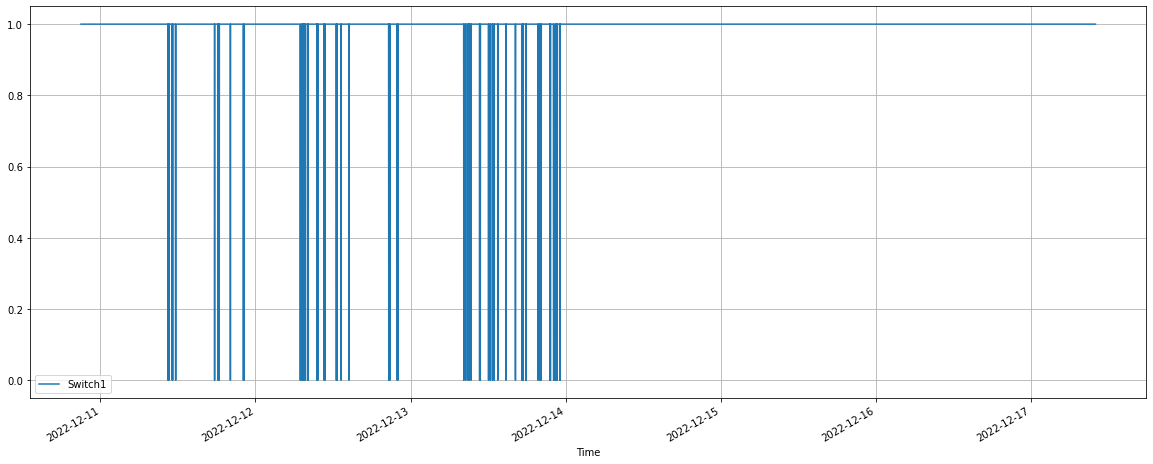

In [78]:
# 1 == Door closed, 0 == Door open
df1_5.plot.line(x='Time', y = ["Switch1"], figsize=(20,8), grid=True)

In [79]:
# Add column to be able to figure out if a condition shift was done
df1_5['CellBefore'] = df1_5['Switch1'].shift(periods=1)

In [80]:
# delete the rows where there was no state change
rows_to_delete1_5_1 = df1_5.loc[((df1_5['CellBefore'] == 1) & (df1_5['Switch1'] == 1)) | ((df1_5['CellBefore'] == 0) & (df1_5['Switch1'] == 0))]
df1_5 = df1_5.drop(rows_to_delete1_5_1.index)

In [81]:
df1_5

index                Time  Switch1  CellBefore
69831      0 2022-12-10 21:00:00        1         NaN
71447      0 2022-12-11 10:28:31        0         1.0
71448      0 2022-12-11 10:29:01        1         0.0
71457      0 2022-12-11 10:33:31        0         1.0
71458      0 2022-12-11 10:34:01        1         0.0
...      ...                 ...      ...         ...
78701      0 2022-12-13 23:05:37        1         0.0
78702      0 2022-12-13 23:06:07        0         1.0
78704      0 2022-12-13 23:07:07        1         0.0
78709      0 2022-12-13 23:09:37        0         1.0
78710      0 2022-12-13 23:10:07        1         0.0

[141 rows x 4 columns]

In [82]:
# Add new column that contains the calculation of the timedifference between the rows
df1_5['Timediff'] = df1_5['Time'].diff()

In [83]:
df1_5

index                Time  Switch1  CellBefore        Timediff
69831      0 2022-12-10 21:00:00        1         NaN             NaT
71447      0 2022-12-11 10:28:31        0         1.0 0 days 13:28:31
71448      0 2022-12-11 10:29:01        1         0.0 0 days 00:00:30
71457      0 2022-12-11 10:33:31        0         1.0 0 days 00:04:30
71458      0 2022-12-11 10:34:01        1         0.0 0 days 00:00:30
...      ...                 ...      ...         ...             ...
78701      0 2022-12-13 23:05:37        1         0.0 0 days 00:00:30
78702      0 2022-12-13 23:06:07        0         1.0 0 days 00:00:30
78704      0 2022-12-13 23:07:07        1         0.0 0 days 00:01:00
78709      0 2022-12-13 23:09:37        0         1.0 0 days 00:02:30
78710      0 2022-12-13 23:10:07        1         0.0 0 days 00:00:30

[141 rows x 5 columns]

In [84]:
# If timediff is smaller than 1 min --> delete the row
rows_to_delete1_5_2 = df1_5.loc[((df1_5['Timediff'] < '0 days 00:01:00'))]
df1_5 = df1_5.drop(rows_to_delete1_5_2.index)

In [85]:
# Delete the rows with Switch1 = 1 because we only need to consider the cases when the door is open
rows_to_delete1_5_3 = df1_5.loc[df1_5['Switch1'] < 1] 
df1_5 = df1_5.drop(rows_to_delete1_5_3.index)

In [86]:
df1_5.describe()

index  Switch1  CellBefore                   Timediff
count   32.0     32.0        31.0                         31
mean     0.0      1.0         0.0  0 days 00:02:05.806451612
std      0.0      0.0         0.0  0 days 00:01:22.128930897
min      0.0      1.0         0.0            0 days 00:01:00
25%      0.0      1.0         0.0            0 days 00:01:00
50%      0.0      1.0         0.0            0 days 00:01:30
75%      0.0      1.0         0.0            0 days 00:03:00
max      0.0      1.0         0.0            0 days 00:06:30

In [87]:
# calculate the sum of all values in the above df
sumdf1_5 = df1_5['Timediff'].sum()
sumdf1_5

Timedelta('0 days 01:05:00')